In [1]:
# imports

import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
%matplotlib inline

In [2]:
# helper function to load rgb images

def load_rgb(path):
    return cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)

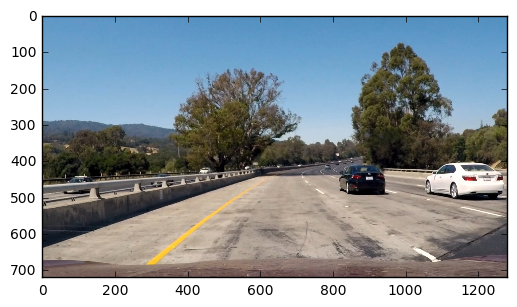

In [3]:
# let's see an example of a test image

img = load_rgb('test_images/test1.jpg')
plt.imshow(img)

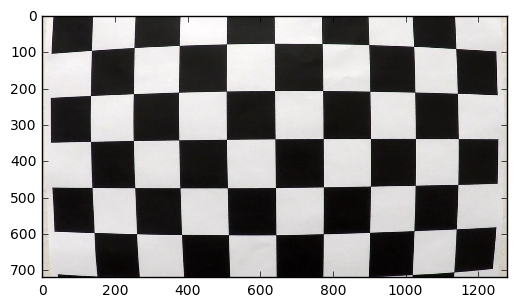

In [4]:
# let's get ready with calibration, here's an example 

img = load_rgb('camera_cal/calibration1.jpg')
plt.imshow(img)

In [5]:
# calibration that runs through all calibration images
# and the undistort function that uses the calibration results

def calibrate(nx, ny):
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((ny*nx,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('camera_cal/cal*.jpg')
    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            img = cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
    
    img_size = (img.shape[1], img.shape[0])
    
    return cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)


ret, mtx, dist, rvecs, tvecs = calibrate(9, 6)

def undistort(image):
    return cv2.undistort(image, mtx, dist, None, mtx)

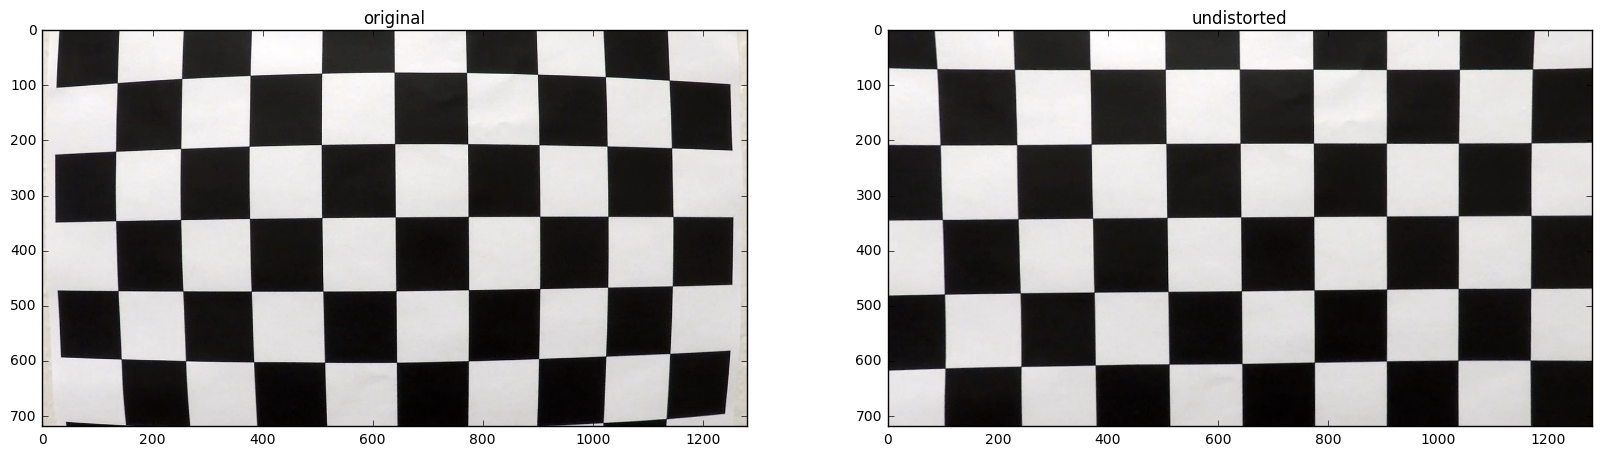

In [6]:
# displaying an example result of undistorting

img = load_rgb('camera_cal/calibration1.jpg')
undistorted = undistort(img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('original')
ax2.imshow(undistorted)
ax2.set_title('undistorted')

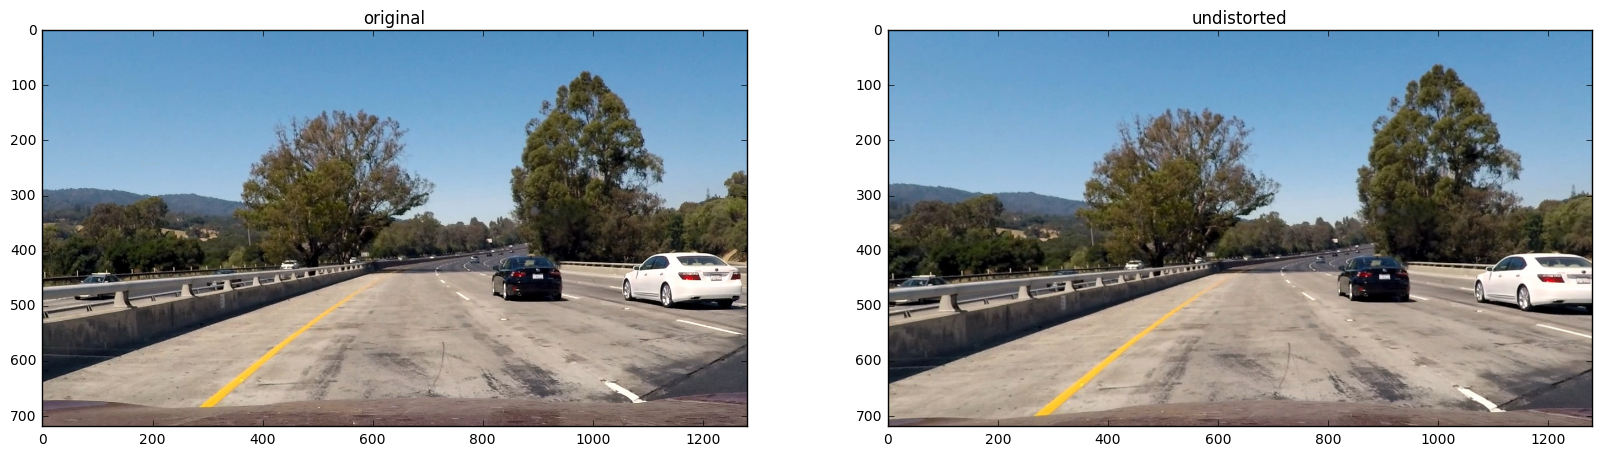

In [7]:
# examining results of undistorting on a test image

img = load_rgb('test_images/test1.jpg')
undistorted = undistort(img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('original')
ax2.imshow(undistorted)
ax2.set_title('undistorted')

In [8]:
# perspective tranformation

src =  np.float32([[250,700],[1200,700],[550,450],[750,450]])
dst = np.float32([[250,700],[1200,700],[300,50],[1000,50]])

def perspective_transform(image):
    h, w, d = image.shape
    transform = cv2.getPerspectiveTransform(src, dst)
    reverse_transform = cv2.getPerspectiveTransform(dst, src)
    return cv2.warpPerspective(image, transform, (w, h)), reverse_transform

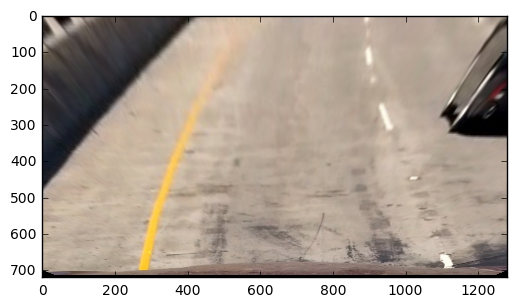

In [9]:
# displaying an example of persepctive transformtion (warping)

warped, reverse_transform = perspective_transform(undistorted)
plt.imshow(warped)

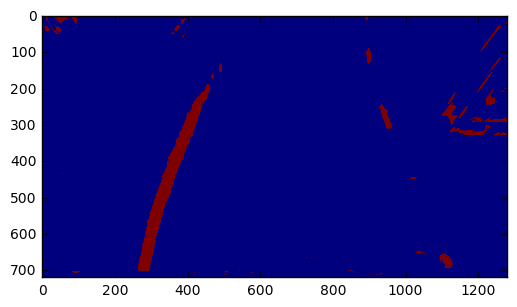

In [10]:
# applying yellow and white thresholds on HSV of the image

yellow_threshold = np.array([[ 0, 80, 0], [ 80, 255, 255]])
white_threshold  = np.array([[ 0, 0, 200], [ 255, 30, 255]])

def range_threshold(image, low, high):
    return cv2.inRange(image, low, high)

def filter_white_and_yellow(image):
    HSV = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

    yellow = range_threshold(HSV, yellow_threshold[0], yellow_threshold[1])
    white = range_threshold(HSV, white_threshold[0], white_threshold[1])
    return cv2.bitwise_or(yellow, white)

plt.imshow(filter_white_and_yellow(warped))

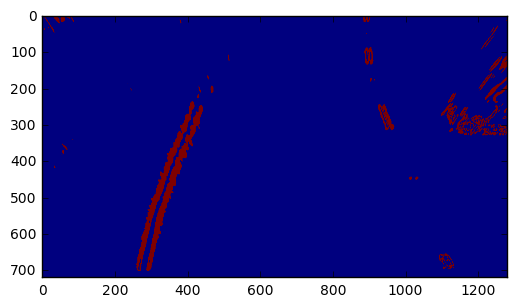

In [11]:
# applying horizontal sobel filtering

def sobel_x(image):
    HLS = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    S = HLS[:,:,2]

    sobel = cv2.Sobel(S, cv2.CV_64F, 1, 0, ksize=13)
    abs_sobel = np.absolute(sobel)
    abs_sobel_max = np.max(abs_sobel)

    def tr(threshold):
        return abs_sobel_max * threshold / 255

    return np.uint8((abs_sobel > tr(20)) & (abs_sobel < tr(100)))

plt.imshow(sobel_x(warped))

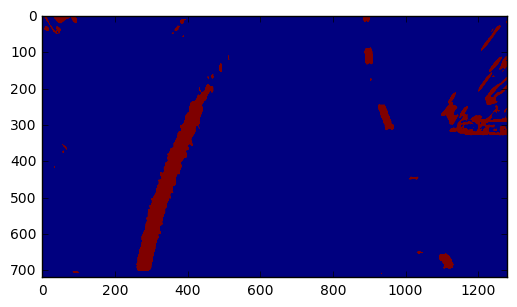

In [12]:
# combining the yellow/white and sobel filtering

combined = np.uint8((filter_white_and_yellow(warped) >= .5)|(sobel_x(warped) >= .5))
blur = cv2.GaussianBlur(combined, (9,9), 0)

plt.imshow(blur)

In [13]:
# the algorithm for finding lanes, using sliding windows

def find_lanes(image, nwindows = 10):
    minpix = 20
    margin = 80

    height = image.shape[0]//nwindows
    
    histogram = np.sum(image[image.shape[0]//2:,:], axis=0)
    midpoint = histogram.shape[0]//2
    
    leftx_current = np.argmax(histogram[margin:midpoint]) + margin
    rightx_current = np.argmax(histogram[midpoint:(histogram.shape[0] - margin)]) + midpoint

    nonzeroy, nonzerox = image.nonzero()
        
    left_lane_inds = []
    right_lane_inds = []
    rectangle_data = []

    # Step through the windows
    for i in range(nwindows):
        r = 1.5 * (i / nwindows)
        y_low = image.shape[0] - (i + 1) * height
        y_high = image.shape[0] - i * height
        xleft_low = int(leftx_current - margin * (1.5 - r))
        xleft_high = int(leftx_current + margin * (0.7 + r))
        xright_low = int(rightx_current - margin * (0.7 + r))
        xright_high = int(rightx_current + margin * (1.5 - r))
        
        rectangle_data.append((y_low, y_high, xleft_low, xleft_high, xright_low, xright_high))

        left_inds = ((nonzeroy >= y_low) & (nonzeroy < y_high) & (nonzerox >= xleft_low) & (nonzerox < xleft_high)).nonzero()[0]
        right_inds = ((nonzeroy >= y_low) & (nonzeroy < y_high) & (nonzerox >= xright_low) & (nonzerox < xright_high)).nonzero()[0]
        left_lane_inds.append(left_inds)
        right_lane_inds.append(right_inds)
        
        # re-center
        if len(left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[left_inds]))
        if len(right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[right_inds]))

    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    visualization_data = (left_lane_inds, right_lane_inds, rectangle_data, histogram)
    
    return left_fit, right_fit, visualization_data
    


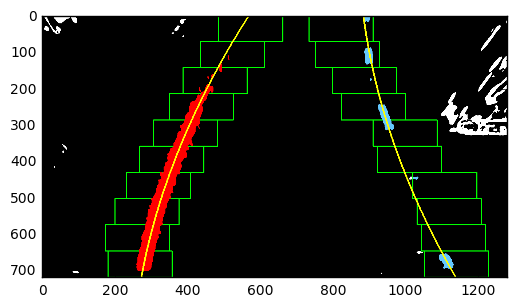

In [14]:
# helper function line_plot
# helper function for visualizing the sliding windows calculations

def line_plot(coefficients, start, length):
    a, b, c = coefficients
    x = np.linspace(start, length-1, length)
    return a*x**2 + b*x + c, x

def visualize_fit(image, left_coe, right_coe, visualization_data):
    left_lane_inds, right_lane_inds, rectangles, histogram = visualization_data

    result = np.uint8(np.dstack((image, image, image))*255)

    # draw rectangles
    for rect in rectangles:
        cv2.rectangle(result, (rect[2],rect[0]), (rect[3],rect[1]), color=(0,255,0), thickness=2) 
        cv2.rectangle(result, (rect[4],rect[0]), (rect[5],rect[1]), color=(0,255,0), thickness=2) 
    
    # draw rectangles
    nonzeroy, nonzerox = image.nonzero()
    result[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    result[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [100, 200, 255]
    
    # draw polyfit
    h = image.shape[0]
    lx, ly = line_plot(left_coe, 0, h)
    rx, ry = line_plot(right_coe, 0, h)
    
    cv2.polylines(result, [np.int32([lx, ly]).T], isClosed=False, color=(255,255,0), thickness=3)
    cv2.polylines(result, [np.int32([rx, ry]).T], isClosed=False, color=(255,255,0), thickness=3)
    
    return result

left_fit, right_fit, visualization_data = find_lanes(blur)
visualization = visualize_fit(blur, left_fit, right_fit, visualization_data)
plt.imshow(visualization)

In [15]:
# find lanes by proximity assumption of the previous fit

def line_plot_x(coefficients, x):
    a, b, c = coefficients
    return a*x**2 + b*x + c

def find_lanes_continuous(image, left_coe_prev, right_coe_prev):
    nonzeroy, nonzerox = image.nonzero()
    margin = 80
    
    left_previous = line_plot_x(left_coe_prev, nonzeroy)
    right_previous = line_plot_x(right_coe_prev, nonzeroy)
    
    left_lane_inds = ((nonzerox > (left_previous - margin)) & (nonzerox < (left_previous + margin))) 
    right_lane_inds = ((nonzerox > (right_previous - margin)) & (nonzerox < (right_previous + margin)))  

    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    left_coe = np.polyfit(lefty, leftx, 2)
    right_coe = np.polyfit(righty, rightx, 2)
    
    return left_coe, right_coe, (left_lane_inds, right_lane_inds)

In [16]:
# calculate the lane curvature and distance from lane center

def curv_rad_and_center_dist(bin_img, l_fit, r_fit, l_lane_inds, r_lane_inds):
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    left_curverad, right_curverad, center_dist = (0, 0, 0)

    h = bin_img.shape[0]
    ploty = np.linspace(0, h-1, h)
    y_eval = np.max(ploty)
  
    nonzeroy, nonzerox = bin_img.nonzero()
    leftx = nonzerox[l_lane_inds]
    lefty = nonzeroy[l_lane_inds] 
    rightx = nonzerox[r_lane_inds]
    righty = nonzeroy[r_lane_inds]
    
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    car_position = bin_img.shape[1]/2
    l_fit_x_int = l_fit[0]*h**2 + l_fit[1]*h + l_fit[2]
    r_fit_x_int = r_fit[0]*h**2 + r_fit[1]*h + r_fit[2]
    lane_center_position = (r_fit_x_int + l_fit_x_int) /2
    center_dist = (car_position - lane_center_position) * xm_per_pix
    
    return left_curverad, right_curverad, center_dist

In [17]:
# an example of calculating the radius and distance from center

left_fit, right_fit, visualization_data = find_lanes(blur)
left_lane_inds, right_lane_inds, rectangles, histogram = visualization_data
rad_l, rad_r, d_center = curv_rad_and_center_dist(blur, left_fit, right_fit, left_lane_inds, right_lane_inds)

print('Radius of curvature for example:', rad_l, 'm,', rad_r, 'm')
print('Distance from lane center for example:', d_center, 'm')

Radius of curvature for example: 520.929726733 m, 534.106700502 m
Distance from lane center for example: -0.341462693404 m


In [18]:
# draw the lanes on the original image

def draw_lane(original, binary, l_fit, r_fit, reverse_transform):
    result = np.copy(original)
    
    blank = np.zeros_like(binary).astype(np.uint8)
    augmentation = np.dstack((blank, blank, blank))
    
    h, w = binary.shape
    y = np.linspace(0, h-1, h)
    lx = line_plot_x(l_fit, y)
    rx = line_plot_x(r_fit, y)

    pts_left = np.array([np.transpose(np.vstack([lx, y]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([rx, y])))])
    pts = np.hstack((pts_left, pts_right))

    cv2.fillPoly(augmentation, np.int_([pts]), (0,255, 0))
    cv2.polylines(augmentation, np.int32([pts_left]), isClosed=False, color=(255,0,255), thickness=15)
    cv2.polylines(augmentation, np.int32([pts_right]), isClosed=False, color=(0,255,255), thickness=15)

    dewarped = cv2.warpPerspective(augmentation, reverse_transform, (w, h)) 
    return cv2.addWeighted(result, 1, dewarped, 0.5, 0)

In [19]:
# helper function to add the textual information on the image

def add_details(image, left_curverad, right_curverad, dist_offset):
    font = cv2.FONT_HERSHEY_COMPLEX
    cv2.putText(image,'Left radius of curvature  = %.2f m'%(left_curverad), (50,50), font, 1, (255,255,255), 2, cv2.LINE_AA)
    cv2.putText(image,'Right radius of curvature = %.2f m'%(right_curverad), (50,80), font, 1, (255,255,255), 2, cv2.LINE_AA)
    cv2.putText(image,'Vehicle position : %.2f cm %s from center'%(abs(dist_offset), 'left' if dist_offset < 0 else 'right'), (50,120), font, 1, (255,255,255), 2, cv2.LINE_AA)
    return image

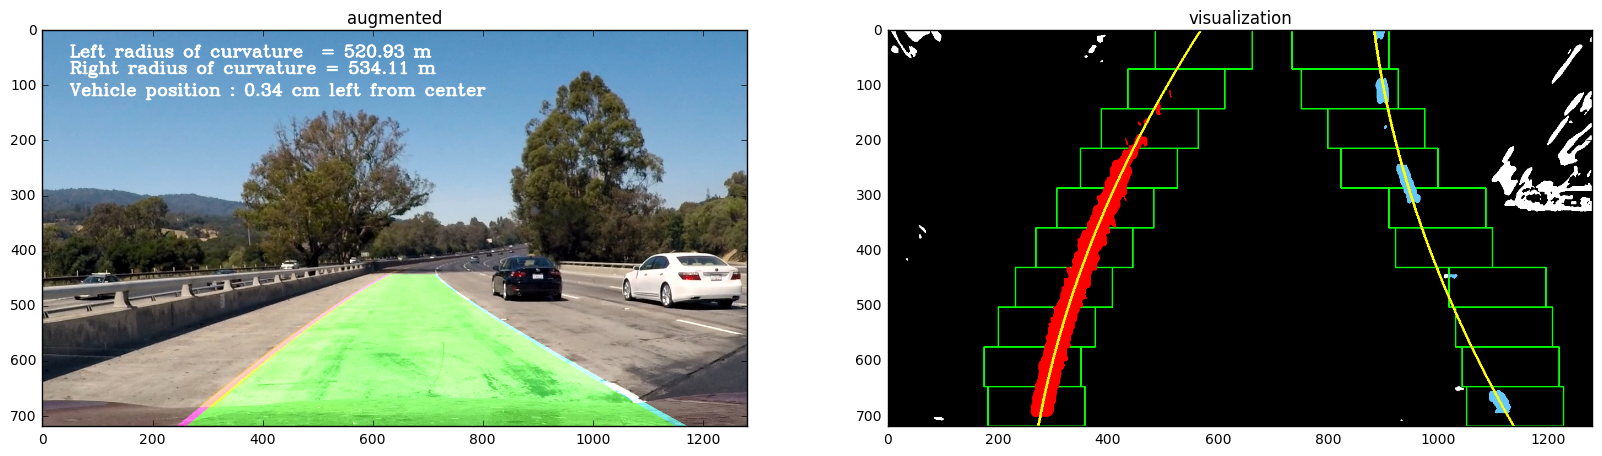

In [20]:
# an example for finding the lanes, and displaying the original image, augmented with the lanes (and lane area),
# and textual information, as well as the sliding windows calculation visualization

left_fit, right_fit, visualization_data = find_lanes(blur)
visualization = visualize_fit(blur, left_fit, right_fit, visualization_data)
augmented = draw_lane(img, blur, left_fit, right_fit, reverse_transform)

left_lane_inds, right_lane_inds, rectangles, histogram = visualization_data
rad_l, rad_r, d_center = curv_rad_and_center_dist(blur, left_fit, right_fit, left_lane_inds, right_lane_inds)
add_details(augmented, rad_l, rad_r, d_center)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(augmented)
ax1.set_title('augmented')
ax2.imshow(visualization)
ax2.set_title('visualization')

In [21]:
# a helper method to calculate the entire pipeline of an image (sums up all we've done so far)

def pipeline(image, visualization = True):
    undistorted = undistort(image)
    transformed, reverse_transform = perspective_transform(undistorted)
    filtered = np.uint8((filter_white_and_yellow(transformed) >= .5)|(sobel_x(transformed) >= .5))
    current = cv2.GaussianBlur(filtered, (9,9), 0)
    
    left_fit, right_fit, visualization_data = find_lanes(current)
    
    augmented = draw_lane(undistorted, current, left_fit, right_fit, reverse_transform)
    if visualization:
        current = visualize_fit(current, left_fit, right_fit, visualization_data)

    return augmented, current

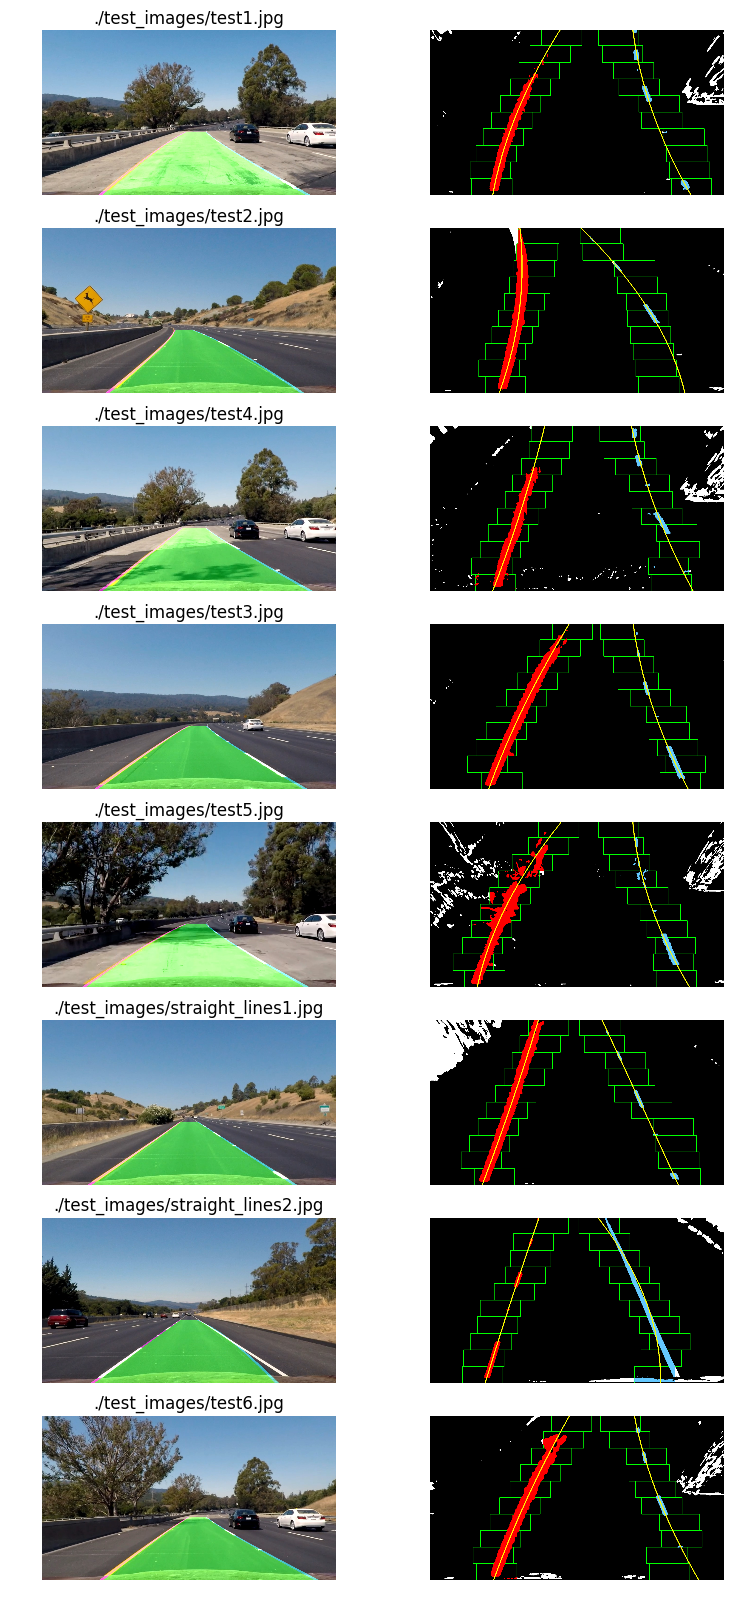

In [22]:
# displaying all test images with results for inspection

images = glob.glob('./test_images/*.jpg')
                                          
# Set up plot
fig, axs = plt.subplots(len(images), 2, figsize=(10, 20))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
                  
i = 0
for image in images:
    img = load_rgb(image)
    augmented, current = pipeline(img)
    axs[i].imshow(augmented)
    axs[i].axis('off')
    axs[i].set_title(image)
    i += 1
    axs[i].imshow(current)
    axs[i].axis('off')
    i += 1

In [24]:
# the pipeline to use for the video augmentation (similar to the previous pipeline)

first = True
left_fit = None
right_fit = None

def video_pipeline(image):
    global first
    global left_fit
    global right_fit
    undistorted = undistort(image)
    transformed, reverse_transform = perspective_transform(undistorted)
    filtered = np.uint8((filter_white_and_yellow(transformed) >= .5)|(sobel_x(transformed) >= .5))
    current = cv2.GaussianBlur(filtered, (9,9), 0)
    
    if first:
        left_fit, right_fit, visualization_data = find_lanes(current)
        left_lane_inds, right_lane_inds, rec, hist = visualization_data
        rad_l, rad_r, d_center = curv_rad_and_center_dist(current, left_fit, right_fit, left_lane_inds, right_lane_inds)

        first = False
    else:
        left_fit, right_fit, lane_inds = find_lanes_continuous(current, left_fit, right_fit)
        left_lane_inds, right_lane_inds = lane_inds
        rad_l, rad_r, d_center = curv_rad_and_center_dist(current, left_fit, right_fit, left_lane_inds, right_lane_inds)
    
    result = draw_lane(undistorted, current, left_fit, right_fit, reverse_transform)
    add_details(result, rad_l, rad_r, d_center)
    return result

In [25]:
from moviepy.editor import VideoFileClip


In [ ]:
first = True
video_input = VideoFileClip('project_video.mp4')
processed_video = video_input.fl_image(video_pipeline)
%time processed_video.write_videofile('project_video_output.mp4', audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


 86%|████████▌ | 1084/1261 [03:19<00:32,  5.53it/s]

In [ ]:
first = True
video_input = VideoFileClip('challenge_video.mp4')
processed_video = video_input.fl_image(video_pipeline)
%time processed_video.write_videofile('challenge_video_output.mp4', audio=False)

In [ ]:
first = True
video_input = VideoFileClip('harder_challenge_video.mp4')
processed_video = video_input.fl_image(video_pipeline)
%time processed_video.write_videofile('harder_challenge_video_output.mp4', audio=False)